#### Importing the Libraries

In [ ]:
from math import sqrt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

#### Loading data/ Reading the dataset

In [ ]:
df = pd.read_csv("IS733_dataset_emo_label.csv")
df


,File_Name,Text,neu,hap,sad,ang,sur,fea,dis,fru,exc,xxx,Positive,Negative,Score,Label
0,Ses01M_impro01,"Next.\n Yes, me. Okay, okay here we go.\n My ...",0.061538,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.384615,0.000000,0.323077,0.000000,0.615385,False,0
1,Ses01M_impro02,"Hey, Joy come in here.\n What's happening?\n ...",0.040816,0.000000,0.530612,0.000000,0.020408,0.000000,0.020408,0.142857,0.000000,0.244898,0.020408,0.673469,False,0
2,Ses01M_impro03,The craziest thing just happened to me.\n Wha...,0.150943,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.754717,0.075472,0.773585,0.000000,True,1
3,Ses01M_impro07,Check this out. You know how I've told you I...,0.100000,0.128571,0.000000,0.000000,0.028571,0.000000,0.014286,0.000000,0.471429,0.257143,0.628571,0.000000,True,1
4,Ses01M_impro06,"You okay?\n Yeah, I'm just-- yeah\n Just kind...",0.403226,0.000000,0.564516,0.000000,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.000000,0.564516,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,Ses05M_impro02,"What is it?\n Sweetheart, I've got to tell yo...",0.017241,0.000000,0.379310,0.000000,0.034483,0.103448,0.000000,0.086207,0.017241,0.362069,0.051724,0.568966,False,0
147,Ses05M_impro06,"Ryan, what's wrong?\n I just got some bad new...",0.000000,0.000000,0.727273,0.045455,0.000000,0.000000,0.136364,0.000000,0.000000,0.090909,0.000000,0.772727,False,0
148,Ses05M_impro07,Guess what?\n What?\n I got it. I got accept...,0.147541,0.213115,0.000000,0.000000,0.008197,0.000000,0.016393,0.000000,0.516393,0.098361,0.737705,0.000000,True,1
149,Ses05M_impro05,Hi. Um- My luggage didn't come out of the co...,0.733333,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.200000,0.000000,0.044444,0.022222,0.200000,False,0


In [ ]:
df.iloc[:,1]

0       Next.\n Yes, me. Okay, okay here we go.\n My ...
1       Hey, Joy come in here.\n What's happening?\n ...
2       The craziest thing just happened to me.\n Wha...
3       Check this out.  You know how I've told you I...
4       You okay?\n Yeah, I'm just-- yeah\n Just kind...
                             ...                        
146     What is it?\n Sweetheart, I've got to tell yo...
147     Ryan, what's wrong?\n I just got some bad new...
148     Guess what?\n What?\n I got it.  I got accept...
149     Hi. Um-  My luggage didn't come out of the co...
150     Uh, God.  I don't know what to do anymore.  L...
Name: Text, Length: 151, dtype: object

In [ ]:
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 151 entries, 0 to 150
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File_Name  151 non-null    object 
 1   Text       151 non-null    object 
 2   neu        151 non-null    float64
 3   hap        151 non-null    float64
 4   sad        151 non-null    float64
 5   ang        151 non-null    float64
 6   sur        151 non-null    float64
 7   fea        151 non-null    float64
 8   dis        151 non-null    float64
 9   fru        151 non-null    float64
 10  exc        151 non-null    float64
 11  xxx        151 non-null    float64
dtypes: float64(10), object(2)
memory usage: 15.3+ KB


In [ ]:
pip install langdetect

     |████████████████████████████████| 981 kB 4.2 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=f110ce207a1c1c07f99fcbd3b9e41f931731494afa7aa41adbbcc63b641bd8d4
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
from langdetect import detect
detect("سلام به همه")

'fa'

In [ ]:

from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# language is determined to hold all language labels
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, it takes the first x index, and joins it with space 
    # so text is defined as a ndarray to keepm the words of the texts into a list
    text = df.iloc[ii]["Text"].split(" ")
    #it set the lang as a type of language (for example en)
    #then in the for loop, the lang is being updated
    lang = "en"
    try:
      #with these codes the author wants the system to detect the language with less than 50 words. 
        if len(text) > 10:
            lang = detect(" ".join(text[:10]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format 
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract... (Eren et al, 2020)
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then (Eren et al, 2020)
                lang = detect(df.iloc[ii]['Text'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language (Eren et al, 2020)   
    languages.append(lang)


100%|██████████| 151/151 [00:01<00:00, 94.40it/s]


In [ ]:
print(len(languages))

151


In [ ]:
#Here we defined a dictionary to count and keep the number of articles related to each detected language 
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 151

{'cy': 2, 'en': 144, 'et': 1, 'id': 2, 'nl': 2}


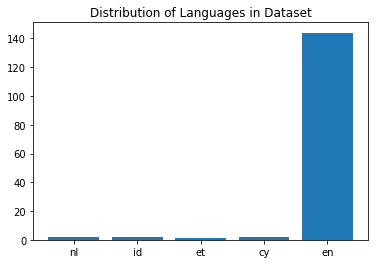

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [ ]:
df = df[df['language'] == 'en'] 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 150
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   File_Name  144 non-null    object 
 1   Text       144 non-null    object 
 2   neu        144 non-null    float64
 3   hap        144 non-null    float64
 4   sad        144 non-null    float64
 5   ang        144 non-null    float64
 6   sur        144 non-null    float64
 7   fea        144 non-null    float64
 8   dis        144 non-null    float64
 9   fru        144 non-null    float64
 10  exc        144 non-null    float64
 11  xxx        144 non-null    float64
 12  Positive   144 non-null    float64
 13  Negative   144 non-null    float64
 14  Score      144 non-null    bool   
 15  Label      144 non-null    int64  
 16  language   144 non-null    object 
dtypes: bool(1), float64(12), int64(1), object(3)
memory usage: 19.3+ KB


In [ ]:
df.to_csv(r'IS733_dataset_emo_label_en.csv')

### Preprocessing 

In [ ]:
df = pd.read_csv("IS733_dataset_en.csv")
df

,Unnamed: 0,File_Name,Text,neu,hap,sad,ang,sur,fea,dis,fru,exc,xxx,language
0,0,Ses01M_impro01,"Next.\n Yes, me. Okay, okay here we go.\n My ...",0.061538,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.384615,0.000000,0.323077,en
1,1,Ses01M_impro02,"Hey, Joy come in here.\n What's happening?\n ...",0.040816,0.000000,0.530612,0.000000,0.020408,0.000000,0.020408,0.142857,0.000000,0.244898,en
2,2,Ses01M_impro03,The craziest thing just happened to me.\n Wha...,0.150943,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.754717,0.075472,en
3,3,Ses01M_impro07,Check this out. You know how I've told you I...,0.100000,0.128571,0.000000,0.000000,0.028571,0.000000,0.014286,0.000000,0.471429,0.257143,en
4,5,Ses01M_impro04,You seem kind of down.\n I'm just mad.\n How ...,0.480769,0.000000,0.000000,0.057692,0.000000,0.000000,0.000000,0.346154,0.000000,0.115385,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,146,Ses05M_impro02,"What is it?\n Sweetheart, I've got to tell yo...",0.017241,0.000000,0.379310,0.000000,0.034483,0.103448,0.000000,0.086207,0.017241,0.362069,en
140,147,Ses05M_impro06,"Ryan, what's wrong?\n I just got some bad new...",0.000000,0.000000,0.727273,0.045455,0.000000,0.000000,0.136364,0.000000,0.000000,0.090909,en
141,148,Ses05M_impro07,Guess what?\n What?\n I got it. I got accept...,0.147541,0.213115,0.000000,0.000000,0.008197,0.000000,0.016393,0.000000,0.516393,0.098361,en
142,149,Ses05M_impro05,Hi. Um- My luggage didn't come out of the co...,0.733333,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.200000,0.000000,0.044444,en


In [ ]:
# Download the spacy bio parser
#%%time
from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz


In [ ]:
#NLP 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step


#### Stopwords
Removing stop-words is a useful technique to preprocess texts when we are working with raw or normalized term frequencies and not tf-idfs, which down weight frequently occurring words (Raschka and Mirjalili, 2, 3rd edition). Stop words are the words that exist in all kind of texts, so they bear a little fruitful information to be used to their cluster recognition (Raschka and Mirjalili, 2, 3rd edition). For example, am, is, and, has are stop words.

In (Raschka and Mirjalili, 2, 3rd edition) the author uses “nltk” stop words with the code below:
Here, we go through removing the stopwords, then we will be able to implement the models with no worries about weight frequently occurring words approach. 

In [ ]:
pip install nltk

In [ ]:
#cite: (Raschka and Mirjalili, 2, 3rd edition)
import nltk
nltk.download('stopwords')
#After we download the stop-words set, we can load and apply the English stop-word set as follows:
from nltk.corpus import stopwords
stop = stopwords.words('english')
print(len(stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
179


As we can see in the cell above, there are 179 stopwords in English that we have imported. 

In [ ]:
import string

punctuations = string.punctuation

print(len(punctuations))

32


In [ ]:
df

,Unnamed: 0,File_Name,Text,neu,hap,sad,ang,sur,fea,dis,fru,exc,xxx,language
0,0,Ses01M_impro01,"Next.\n Yes, me. Okay, okay here we go.\n My ...",0.061538,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.384615,0.000000,0.323077,en
1,1,Ses01M_impro02,"Hey, Joy come in here.\n What's happening?\n ...",0.040816,0.000000,0.530612,0.000000,0.020408,0.000000,0.020408,0.142857,0.000000,0.244898,en
2,2,Ses01M_impro03,The craziest thing just happened to me.\n Wha...,0.150943,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.754717,0.075472,en
3,3,Ses01M_impro07,Check this out. You know how I've told you I...,0.100000,0.128571,0.000000,0.000000,0.028571,0.000000,0.014286,0.000000,0.471429,0.257143,en
4,5,Ses01M_impro04,You seem kind of down.\n I'm just mad.\n How ...,0.480769,0.000000,0.000000,0.057692,0.000000,0.000000,0.000000,0.346154,0.000000,0.115385,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,146,Ses05M_impro02,"What is it?\n Sweetheart, I've got to tell yo...",0.017241,0.000000,0.379310,0.000000,0.034483,0.103448,0.000000,0.086207,0.017241,0.362069,en
140,147,Ses05M_impro06,"Ryan, what's wrong?\n I just got some bad new...",0.000000,0.000000,0.727273,0.045455,0.000000,0.000000,0.136364,0.000000,0.000000,0.090909,en
141,148,Ses05M_impro07,Guess what?\n What?\n I got it. I got accept...,0.147541,0.213115,0.000000,0.000000,0.008197,0.000000,0.016393,0.000000,0.516393,0.098361,en
142,149,Ses05M_impro05,Hi. Um- My luggage didn't come out of the co...,0.733333,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.200000,0.000000,0.044444,en


In [ ]:


# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df['Text'])



0      Next. Yes, me. Okay, okay go. My window open. ...
1      Hey, Joy come here. What's happening? I go bac...
2      The craziest thing happened me. What? This gir...
3      Check out. You know I've told I've really like...
4      You seem kind down. I'm mad. How come? It's--I...
                             ...                        
139    What it? Sweetheart, I've got tell something. ...
140    Ryan, what's wrong? I got bad news. What? My f...
141    Guess what? What? I got it. I got accepted U.S...
142    Hi. Um- My luggage come conveyor thingy. Hmm. ...
143    Uh, God. I know anymore. Like I said -- What m...
Name: Text, Length: 144, dtype: object


In [ ]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

More stopwords can be detected

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
print(len(STOP_WORDS))

326


In [ ]:
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (STOP_WORDS)]))
print(df)

     Unnamed: 0       File_Name  ...       xxx  language
0             0  Ses01M_impro01  ...  0.323077        en
1             1  Ses01M_impro02  ...  0.244898        en
2             2  Ses01M_impro03  ...  0.075472        en
3             3  Ses01M_impro07  ...  0.257143        en
4             5  Ses01M_impro04  ...  0.115385        en
..          ...             ...  ...       ...       ...
139         146  Ses05M_impro02  ...  0.362069        en
140         147  Ses05M_impro06  ...  0.090909        en
141         148  Ses05M_impro07  ...  0.098361        en
142         149  Ses05M_impro05  ...  0.044444        en
143         150  Ses05M_impro04  ...  0.074074        en

[144 rows x 14 columns]


Delete punctuations:

In [ ]:
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (punctuations)]))
print(df)

     Unnamed: 0       File_Name  ...       xxx  language
0             0  Ses01M_impro01  ...  0.323077        en
1             1  Ses01M_impro02  ...  0.244898        en
2             2  Ses01M_impro03  ...  0.075472        en
3             3  Ses01M_impro07  ...  0.257143        en
4             5  Ses01M_impro04  ...  0.115385        en
..          ...             ...  ...       ...       ...
139         146  Ses05M_impro02  ...  0.362069        en
140         147  Ses05M_impro06  ...  0.090909        en
141         148  Ses05M_impro07  ...  0.098361        en
142         149  Ses05M_impro05  ...  0.044444        en
143         150  Ses05M_impro04  ...  0.074074        en

[144 rows x 14 columns]


In [ ]:
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
#this cell is added to be used in LDA section, but it is important to be kept
df_without_stopwords = df

From the way the TfIdf score is set up, there shouldn't be any significant difference in removing the stopwords. The whole point of the Idf is exactly to remove words with no semantic value from the corpus. If you do add the stopwords, the Idf should get rid of it. However, working without the stopwords in your documents will make the number of features smaller, which might have a slight computational advantage. Removing stop-words is a useful technique to preprocess texts when we are working with raw or normalized term frequencies and not tf-idfs, which down weight frequently occurring words (Raschka and Mirjalili, 2, 3rd edition).

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Text'])



In [ ]:
print(vectorizer.get_feature_names_out())

['able' 'about' 'above' ... 'zero' 'zeros' 'zipped']


In [ ]:
X.shape

(144, 3218)

Now, we are faced with a sparse matrix, so there are 3283 features. It is a huge feature matrix, we need to do dimentionally reduction using a method such as Principle Component Analysis (PCA). 

Principle Component Analysis (PCA) is used to reduce the number of dimensions while still keeping 95% variance (defined by n_components). PCA removes some noise/outliers from the data, and makes the clustering problem easier. Although k-means needs the reduced feature matrix, t-SNE does not need it. It can work on the original X data set well.

In [ ]:
# using PCA library from sklearn gives us 97 new features to keep %95 of the variance of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(144, 91)

In [ ]:
#cite: https://stackoverflow.com/questions/31909945/obtain-eigen-values-and-vectors-from-sklearn-pca/31941631
eigen_vals = pca.explained_variance_
print(eigen_vals)
print(len(eigen_vals))



[0.0586836  0.05480894 0.04783868 0.04624306 0.04013519 0.03173341
 0.03066449 0.0248402  0.01523999 0.01421168 0.0127909  0.01103439
 0.01073469 0.01020249 0.00928189 0.00870286 0.0083692  0.00784678
 0.00748121 0.00678512 0.00675146 0.00655585 0.00634943 0.00632886
 0.00600321 0.00588573 0.00577155 0.00564819 0.00558263 0.00538562
 0.0053399  0.00529888 0.00523173 0.0051678  0.00503591 0.00496836
 0.00483764 0.00482924 0.00480092 0.00464433 0.00461017 0.0045884
 0.00448473 0.00442046 0.004411   0.00437609 0.00423688 0.00418863
 0.00411625 0.00407535 0.0040155  0.0039895  0.0039605  0.0038639
 0.00384526 0.0037243  0.00366731 0.00361417 0.00360156 0.00353955
 0.00347598 0.00341147 0.00335725 0.00327342 0.00318072 0.00315522
 0.00310701 0.00304265 0.00301974 0.00296656 0.00292804 0.00283131
 0.00278971 0.00273005 0.00265569 0.00254653 0.00251904 0.00243738
 0.00231389 0.00216135 0.00210634 0.00205086 0.00190302 0.00187958
 0.00184879 0.00175391 0.00168973 0.00167021 0.00163399 0.001596

According to Raschka and Mirjalili, "using the NumPy cumsum function, we can then calculate the cumulative sum of explained variances, which we will then plot via Matplotlib's step function" (Raschka and Mirjalili, 2, 3rd edition):

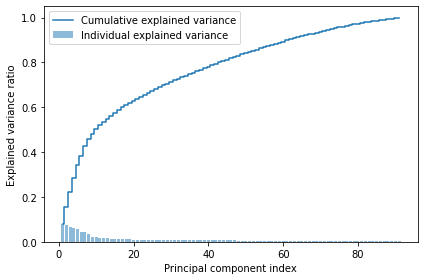

In [ ]:
# cite: (Raschka and Mirjalili, 2, 3rd edition)
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
           sorted(eigen_vals, reverse=True)]         
cum_var_exp = np.cumsum(var_exp)
import matplotlib.pyplot as plt
plt.bar(range(1,92), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,92), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


According to the plot above, to keep 0.95% explained variance ratio almost 90 principal components are enough! However, we use all 97 principal components because PCA of SKlearn has given this number of principal components to maintain 0.95% explained variance ratio. Comparing two methods to implement PCA shows that SKlearn PCA gives more principal components than really needed ones.

### Unsupervised Modeling 
#### K-means
To use k-means as the main clustering algorithm, we need to identify the optimized k since k is a hyperparameter of k-means algorithm.
The optimized k value

To find the optimized k value for k-means elbow method is used. It calculates distortion at different k values. The disortation here means the sum of squared distances from each point to its assigned center. We also plot the disortaion and k, then, there will be a k value after which decreases in distortion are too small. We will choose this as the k hyperparameter.


In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

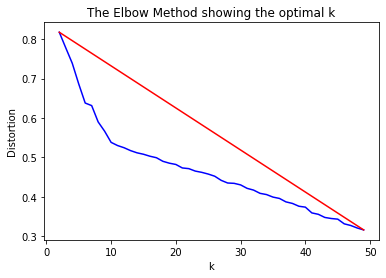

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=12, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)


In [ ]:
# X_reduced and y_pred are both two ndarrays that we want to have them in a dataframe so we use the code below
df_x = pd.DataFrame(X_reduced)
df_y= pd.DataFrame(y_pred)
df_main = pd.merge(df_x, df_y,how='inner', left_index=True, right_index=True)
df_main


,0_x,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,0_y
0,0.040606,0.041486,-0.076103,-0.095034,-0.198333,0.008018,0.051948,0.422415,-0.017369,0.482821,-0.199921,0.027398,-0.226824,-0.126384,-0.398923,-0.063665,0.016117,0.004195,0.029032,-0.022445,-0.019454,0.049424,-0.008044,0.030872,0.028335,-0.042822,-0.002856,-0.037370,0.020431,0.028769,0.003576,0.012566,0.017369,-0.004914,-0.004215,0.017443,0.030794,0.000588,0.028511,0.009695,...,0.003734,-0.000499,-0.048901,-0.016484,0.015854,0.002407,-0.094557,0.042017,0.055019,-0.005823,0.019383,0.009399,-0.044006,-0.017367,0.029517,0.021498,-0.012470,-0.015090,0.023133,-0.002892,-0.041067,-0.027080,0.067424,0.015361,-0.019993,-0.059969,-0.050297,-0.132786,0.311223,-0.129324,0.111193,0.017847,0.054604,0.005113,-0.018755,0.021166,-0.010120,-0.032693,-0.013981,9
1,-0.001424,-0.021015,-0.074428,-0.063767,-0.044771,0.024378,-0.010796,0.024194,0.019579,0.082474,0.397501,-0.084114,-0.123801,0.123820,-0.124134,0.075149,-0.039033,0.044997,-0.080347,-0.131805,0.092208,0.050505,0.194254,0.105086,0.120102,0.369013,-0.052238,0.106939,0.084428,0.120352,-0.276631,0.116764,-0.208199,-0.151360,0.032421,0.147138,-0.044368,0.089882,-0.004554,0.162693,...,0.020794,0.021087,-0.004285,-0.064025,-0.016170,0.068691,0.089816,0.030507,-0.071544,-0.052559,0.062877,0.022309,0.028513,0.004917,0.052768,-0.003565,0.012105,-0.103402,-0.041961,0.032202,-0.033645,-0.041330,0.043267,-0.041242,0.004243,0.035030,0.004510,0.037588,0.013262,-0.004417,-0.011046,-0.020714,0.016158,0.008048,-0.001324,-0.000301,-0.004632,0.002599,0.005911,11
2,0.003015,-0.026284,-0.206703,-0.165325,-0.106086,0.020978,-0.039520,-0.160413,-0.269480,-0.034909,-0.101171,-0.152530,-0.074704,-0.001900,0.026257,0.052254,0.147262,-0.171710,0.069802,-0.234942,-0.061297,-0.054848,-0.054658,-0.017022,0.015909,0.065880,0.153299,-0.226761,-0.091190,0.062014,-0.026799,-0.246533,-0.011652,-0.005004,-0.050597,0.154828,-0.023524,-0.028689,-0.050027,-0.026715,...,-0.188411,-0.011242,0.079165,-0.060371,-0.069123,0.009313,-0.003610,0.049170,0.129098,0.015974,-0.025885,0.063526,-0.060609,0.055069,0.016454,0.016161,0.022546,0.061219,-0.042619,-0.037857,-0.016808,0.034504,0.026782,0.004206,0.003076,-0.022558,0.031889,-0.017655,0.001568,-0.011462,-0.008916,-0.001509,-0.006894,-0.008768,0.000883,-0.012200,-0.022832,-0.004110,-0.005437,6
3,0.029690,-0.032829,-0.188574,-0.116098,-0.016296,0.048160,-0.041306,-0.131157,-0.119184,0.019552,-0.131956,-0.111213,0.002434,0.010366,0.015537,-0.024833,-0.034736,-0.121866,0.109865,-0.294112,0.069749,-0.246913,0.105536,0.003790,-0.070496,0.077397,-0.179073,-0.170272,-0.194537,0.020931,0.329320,-0.108993,-0.152449,-0.324383,-0.026766,-0.058110,-0.138351,0.114152,0.054732,0.032487,...,0.056097,-0.070546,-0.015898,-0.020197,0.027185,-0.005253,-0.009227,-0.019406,0.011322,0.055149,0.005306,0.009276,0.027498,0.009666,-0.019672,0.017183,0.010137,0.003549,0.005093,0.010507,0.015466,0.006405,-0.002451,0.016860,-0.003418,0.000688,0.015453,0.006390,-0.001206,-0.012429,0.011849,-0.003106,0.008798,-0.016221,0.007501,-0.001189,0.005885,0.003612,0.005717,10
4,-0.012512,-0.090682,-0.220036,-0.078386,-0.069172,-0.017794,0.008809,-0.073035,0.268125,0.011688,-0.228406,-0.330113,0.127776,-0.006639,0.007870,0.027363,0.095620,-0.020094,-0.038070,-0.080950,0.074399,0.076168,0.104364,-0.043600,0.013493,0.018882,-0.040473,-0.027910,-0.035389,0.054138,-0.122300,0.102261,-0.063649,-0.023599,0.049333,0.004748,0.092166,0.100196,-0.041950,0.000516,...,0.015799,0.262983,-0.191029,0.108309,-0.095332,-0.016395,-0.035196,-0.083466,0.084745,0.130900,-0.101392,0.038638,-0.047093,-0.031552,0.000695,-0.078937,-0.004628,0.124473,0.002548,-0.108393,0.086630,-0.015799,-0.045526,-0.021766,0.001599,-0.008461,0.026201,-0.025654,-0.059010,-0.086941,0.022377,0.028318,0.002172,-0.009978,-0.001232,0

In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_reduced, y_pred)
print(score)

0.3330339218568799


### Next Step: Topic Modeling on Each Cluster Using LDA 
Since K-means clustered the articles but did not label the topics we need to create a model to find the most significant words in each cluter. Therefore, the topic modeling finds the keywords of each cluster, so the clusters are more meaningful.

In LDA which is used for topic modeling each document can be described by a distribution of topics and each topic can be described by a distribution of words .

LDA is a generative probabilistic model that is supposed to find groups of words that exist frequently together in different documents. These frequently appearing words suggest the topics of each document (Raschka and Mirjalili, 2, 3rd edition). Given a bag-of-words matrix as input of LDA, LDA decomposes it into two new matrices: 1. A document-to-topic matrix 2. A word-to-topic matrix. According to LDA decomposition, if those two matrixes are multiplied together, the input (the bag-of-words matrix) can be reproduced with the lowest possible error (Raschka and Mirjalili, 2, 3rd edition). The only downside of LDA is that the number of topics is a hyperparameter that has to be specified manually (Raschka and Mirjalili, 2, 3rd edition). In the given research, we determined the number of clusters using Elbow method and k-means. Therefore, the number of topics is 15 in the given research, and the downside of the LDA is handled.

The CountVectorizer is used to create the bag-of-words matrix as input to the LDA. the LatentDirichletAllocation class implemented in scikit-learn to decompose the given dataset and categorize it into different topics. Vividly, in the given research, the LDA should be restricted to 15 topics.




In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
y = df_main['0_y'].tolist()

In [ ]:
df['y'] = y
df

,Unnamed: 0,File_Name,Text,neu,hap,sad,ang,sur,fea,dis,fru,exc,xxx,language,y
0,0,Ses01M_impro01,"Next. Yes, me. Okay, okay go. My window open. ...",0.061538,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.384615,0.000000,0.323077,en,9
1,1,Ses01M_impro02,"Hey, Joy come here. What's happening? I back. ...",0.040816,0.000000,0.530612,0.000000,0.020408,0.000000,0.020408,0.142857,0.000000,0.244898,en,11
2,2,Ses01M_impro03,The craziest thing happened me. What? This gir...,0.150943,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.754717,0.075472,en,6
3,3,Ses01M_impro07,Check out. You know I've told I've like softba...,0.100000,0.128571,0.000000,0.000000,0.028571,0.000000,0.014286,0.000000,0.471429,0.257143,en,10
4,5,Ses01M_impro04,You kind down. I'm mad. How come? It's--I've t...,0.480769,0.000000,0.000000,0.057692,0.000000,0.000000,0.000000,0.346154,0.000000,0.115385,en,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,146,Ses05M_impro02,"What it? Sweetheart, I've got tell something. ...",0.017241,0.000000,0.379310,0.000000,0.034483,0.103448,0.000000,0.086207,0.017241,0.362069,en,11
140,147,Ses05M_impro06,"Ryan, what's wrong? I got bad news. What? My f...",0.000000,0.000000,0.727273,0.045455,0.000000,0.000000,0.136364,0.000000,0.000000,0.090909,en,10
141,148,Ses05M_impro07,Guess what? What? I got it. I got accepted U.S...,0.147541,0.213115,0.000000,0.000000,0.008197,0.000000,0.016393,0.000000,0.516393,0.098361,en,6
142,149,Ses05M_impro05,Hi. Um- My luggage come conveyor thingy. Hmm. ...,0.733333,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.200000,0.000000,0.044444,en,7


In [ ]:
vectorizers = []
    
for ii in range(0, 12):
  vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}'))

In [ ]:


vectorizers[2]

print(len(vectorizers))

12


I need to add the cluster numbers (0_y) from df_main to df, then go through count verctorizing to find the most frequent words in each topic (cluster):

In [ ]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'Text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [ ]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 1

lda_models = []
for ii in range(0, 12):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=1,
                          random_state=42, verbose=False)

For each cluster, we had created a correspoding LDA model in the previous step. We will now fit_transform all the LDA models on their respective cluster vectors

In [ ]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

In [ ]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=30):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [ ]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    # print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [ ]:
all_keywords[7][:]

['like',
 'mean',
 'going',
 'right',
 'lost',
 'dollars',
 'yeah',
 'sorry',
 'understand',
 'luggage',
 'want',
 'dollar',
 'baggage',
 'um-',
 'stuff',
 'yes',
 'people',
 'got',
 'come',
 'actually',
 'maybe',
 'airline',
 'uh-',
 'look',
 'help',
 'check',
 'think',
 'did',
 'flight',
 'lose']

In [ ]:
all_keywords[6][:]


['right',
 'laughter',
 'okay',
 'want',
 'got',
 'good',
 'yes',
 'great',
 'excited',
 'awesome',
 'married',
 'god',
 'school',
 'guess',
 'little',
 'gonna',
 'maybe',
 'cool',
 'cause',
 'campus',
 'come',
 'course',
 'time',
 'wow',
 'um-',
 'man',
 'thank',
 'thing',
 'people',
 'way']

In [ ]:
len(all_keywords[1][:])

30

In [ ]:
len(all_keywords)

12

In [ ]:
df

,Unnamed: 0,File_Name,Text,neu,hap,sad,ang,sur,fea,dis,fru,exc,xxx,language,y
0,0,Ses01M_impro01,"Next. Yes, me. Okay, okay go. My window open. ...",0.061538,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.384615,0.000000,0.323077,en,9
1,1,Ses01M_impro02,"Hey, Joy come here. What's happening? I back. ...",0.040816,0.000000,0.530612,0.000000,0.020408,0.000000,0.020408,0.142857,0.000000,0.244898,en,11
2,2,Ses01M_impro03,The craziest thing happened me. What? This gir...,0.150943,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.754717,0.075472,en,6
3,3,Ses01M_impro07,Check out. You know I've told I've like softba...,0.100000,0.128571,0.000000,0.000000,0.028571,0.000000,0.014286,0.000000,0.471429,0.257143,en,10
4,5,Ses01M_impro04,You kind down. I'm mad. How come? It's--I've t...,0.480769,0.000000,0.000000,0.057692,0.000000,0.000000,0.000000,0.346154,0.000000,0.115385,en,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,146,Ses05M_impro02,"What it? Sweetheart, I've got tell something. ...",0.017241,0.000000,0.379310,0.000000,0.034483,0.103448,0.000000,0.086207,0.017241,0.362069,en,11
140,147,Ses05M_impro06,"Ryan, what's wrong? I got bad news. What? My f...",0.000000,0.000000,0.727273,0.045455,0.000000,0.000000,0.136364,0.000000,0.000000,0.090909,en,10
141,148,Ses05M_impro07,Guess what? What? I got it. I got accepted U.S...,0.147541,0.213115,0.000000,0.000000,0.008197,0.000000,0.016393,0.000000,0.516393,0.098361,en,6
142,149,Ses05M_impro05,Hi. Um- My luggage come conveyor thingy. Hmm. ...,0.733333,0.000000,0.000000,0.000000,0.022222,0.000000,0.000000,0.200000,0.000000,0.044444,en,7


[10, 0, 9, 22, 22, 13, 17, 10, 0, 10, 20, 11]


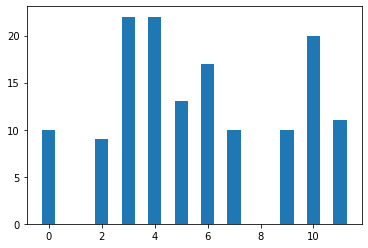

In [ ]:
l = df['y'].values
sum = []
indices = []
i=0
for i in range(0, 12):
  sum.append(0)
  indices.append(i)


for i in l :
  if l[i] == 0:
    sum[0] += 1
  elif l[i] == 1:
    sum[1] += 1
  elif l[i] == 2:
    sum[2] += 1
  elif l[i] == 3:
    sum[3] += 1
  elif l[i] == 4:
    sum[4] += 1
  elif l[i] == 5:
    sum[5] += 1
  elif l[i] == 6:
    sum[6] += 1
  elif l[i] == 7:
    sum[7] += 1
  elif l[i] == 8:
    sum[8] += 1
  elif l[i] == 9:
    sum[9] += 1
  elif l[i] == 10:
    sum[10] += 1
  elif l[i] == 11:
    sum[11] += 1


 
  i = i+1



plt.bar(indices, sum, 0.5)


print(sum)

Therefore, for each cluster some keywords are assigned. For example, based on the codes above, 30 keywords are recognized for the cluster 2 (index 1). Vividly, each group of keywords is each element of the all_keywords list, so the length of all_keywords list is 15 (but 12 after LDA since it did not have any data in 3 of the clusters) -- the number of different clusters.

###visualization 

For Cluster 7

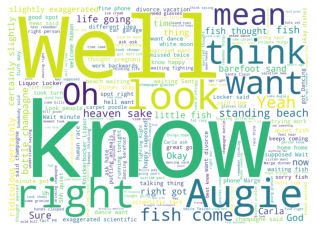

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df0 = df[df['y'] == 0] 
word_cloud = df0["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()


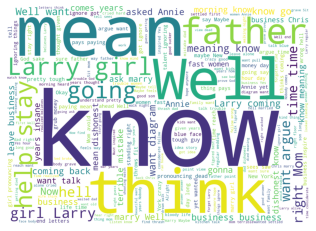

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df1 = df[df['y'] == 1] 
word_cloud = df1["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()


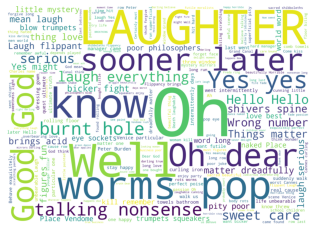

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df2 = df[df['y'] == 2] 
word_cloud = df2["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

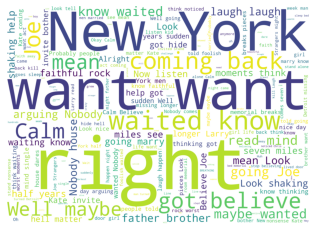

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df3 = df[df['y'] == 3] 
word_cloud = df3["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

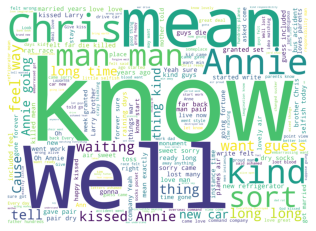

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df4 = df[df['y'] == 4] 
word_cloud = df4["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

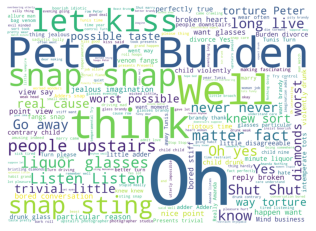

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df5 = df[df['y'] == 5] 
word_cloud = df5["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

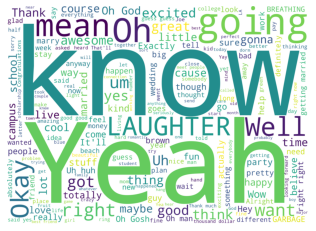

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df6 = df[df['y'] == 6] 
word_cloud = df6["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

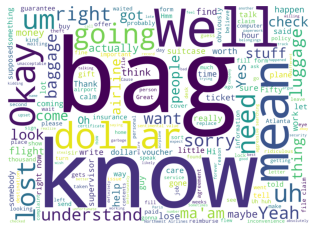

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df7 = df[df['y'] == 7] 
word_cloud = df7["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

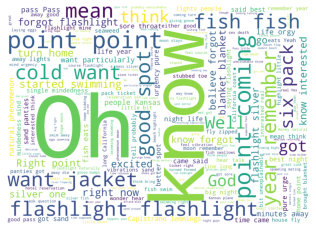

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df8 = df[df['y'] == 8] 
word_cloud = df8["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

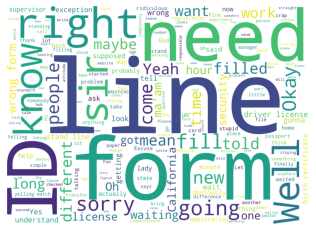

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df9 = df[df['y'] == 9] 
word_cloud = df9["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

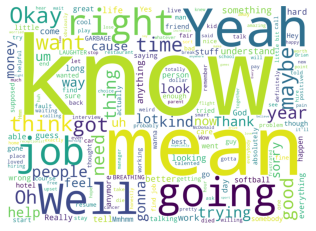

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df10 = df[df['y'] == 10] 
word_cloud = df10["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

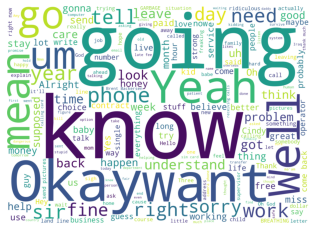

<Figure size 1152x1152 with 0 Axes>

In [ ]:
df11 = df[df['y'] == 11] 
word_cloud = df11["Text"].values
from wordcloud import WordCloud
# Generating the wordcloud 
firstcloud = WordCloud(
                          background_color='white',
                          width=2500,
                          height=1800
                         ).generate(" ".join(word_cloud))
plt.imshow(firstcloud)
plt.axis('off')
plt.figure(figsize=(16, 16))
plt.show()

The code above from : 
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

### Evaluation:

In [ ]:
# function to print out classification model report
def classification_report(model_name, test, pred):
    from sklearn.metrics import precision_score, recall_score
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    
    print(model_name, ":\n")
    print("Accuracy Score: ", '{:,.3f}'.format(float(accuracy_score(test, pred)) * 100), "%")
    print("     Precision: ", '{:,.3f}'.format(float(precision_score(test, pred, average='macro')) * 100), "%")
    print("        Recall: ", '{:,.3f}'.format(float(recall_score(test, pred, average='macro')) * 100), "%")
    print("      F1 score: ", '{:,.3f}'.format(float(f1_score(test, pred, average='macro')) * 100), "%")

In [ ]:
from sklearn.model_selection import train_test_split

# test set size of 20% of the data and the random seed 42 <3
X_train, X_test, y_train, y_test = train_test_split(X_reduced ,y_pred, test_size=0.2, random_state=42)

print("X_train size:", len(X_train))
print("X_test size:", len(X_test), "\n")

X_train size: 115
X_test size: 29 



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier

# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_train, y_train)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_train, sgd_pred)

Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  78.261 %
     Precision:  83.282 %
        Recall:  77.918 %
      F1 score:  77.244 %


In [ ]:
# SGD instance
sgd_clf = SGDClassifier(max_iter=10000, tol=1e-3, random_state=42, n_jobs=4)
# train SGD
sgd_clf.fit(X_test, y_test)

# cross validation predictions
sgd_pred = cross_val_predict(sgd_clf, X_test, y_test, cv=3, n_jobs=4)

# print out the classification report
classification_report("Stochastic Gradient Descent Report (Training Set)", y_test, sgd_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Stochastic Gradient Descent Report (Training Set) :

Accuracy Score:  72.414 %
     Precision:  67.803 %
        Recall:  69.091 %
      F1 score:  66.863 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



### Emotions new version

In [ ]:
X_reduced

array([[ 0.04060598,  0.04148598, -0.07610327, ..., -0.01012037,
        -0.0326933 , -0.01398079],
       [-0.0014243 , -0.02101479, -0.07442799, ..., -0.00463169,
         0.00259861,  0.00591071],
       [ 0.00301465, -0.02628423, -0.20670347, ..., -0.02283218,
        -0.00410965, -0.00543664],
       ...,
       [-0.00178761, -0.05912142, -0.29077041, ..., -0.00083268,
         0.02064523,  0.0361531 ],
       [ 0.00668126, -0.04821747, -0.24420178, ...,  0.00938908,
        -0.01127452, -0.00131679],
       [-0.04253607, -0.09586201, -0.19659166, ...,  0.00142784,
        -0.001998  , -0.01333863]])

In [ ]:
df_label = pd.read_csv("IS733_dataset_emo_label_en.csv")
df_label.iloc[:,16]

0      0
1      0
2      1
3      1
4      0
      ..
139    0
140    0
141    1
142    0
143    0
Name: Label, Length: 144, dtype: int64

In [ ]:


import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier



In [ ]:
X = X_reduced
y = df_label.iloc[:,16]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf = rf.fit(X, y)
y_pred = rf.predict(X)
scoresrf = cross_val_score(rf, X, y, cv=10)
print('Cross-Validation Accuracy Scores', scoresrf)

Cross-Validation Accuracy Scores [0.8        0.93333333 0.93333333 0.86666667 1.         0.78571429
 0.78571429 0.78571429 0.78571429 0.92857143]


In [ ]:
scoresrf = pd.Series(scoresrf)
scoresrf.min(), scoresrf.mean(), scoresrf.max()


(0.7857142857142857, 0.8604761904761904, 1.0)

In [ ]:


fpr, tpr, _ = metrics.roc_curve(y, y_pred)
metrics.auc(fpr, tpr)



0.9875

#Using validation set to tune the hyper parameters:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
rf = RandomForestClassifier(max_depth=1, random_state=0)
rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
classification_report("Random forest Report (Training Set)", y_train, y_pred_train)
classification_report("Random forest Report (Validation Set)", y_val, y_pred_val)

Random forest Report (Training Set) :

Accuracy Score:  76.699 %
     Precision:  38.350 %
        Recall:  50.000 %
      F1 score:  43.407 %
Random forest Report (Validation Set) :

Accuracy Score:  91.667 %
     Precision:  45.833 %
        Recall:  50.000 %
      F1 score:  47.826 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
classification_report("Random forest Report (Training Set)", y_train, y_pred_train)
classification_report("Random forest Report (Validation Set)", y_val, y_pred_val)

Random forest Report (Training Set) :

Accuracy Score:  88.350 %
     Precision:  93.407 %
        Recall:  75.000 %
      F1 score:  79.804 %
Random forest Report (Validation Set) :

Accuracy Score:  91.667 %
     Precision:  45.833 %
        Recall:  50.000 %
      F1 score:  47.826 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
classification_report("Random forest Report (Training Set)", y_train, y_pred_train)
classification_report("Random forest Report (Validation Set)", y_val, y_pred_val)

Random forest Report (Training Set) :

Accuracy Score:  94.175 %
     Precision:  96.471 %
        Recall:  87.500 %
      F1 score:  91.028 %
Random forest Report (Validation Set) :

Accuracy Score:  91.667 %
     Precision:  45.833 %
        Recall:  50.000 %
      F1 score:  47.826 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
rf = RandomForestClassifier(max_depth=4, random_state=0)
rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
classification_report("Random forest Report (Training Set)", y_train, y_pred_train)
classification_report("Random forest Report (Validation Set)", y_val, y_pred_val)

Random forest Report (Training Set) :

Accuracy Score:  98.058 %
     Precision:  98.765 %
        Recall:  95.833 %
      F1 score:  97.201 %
Random forest Report (Validation Set) :

Accuracy Score:  91.667 %
     Precision:  45.833 %
        Recall:  50.000 %
      F1 score:  47.826 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf = rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)
classification_report("Random forest Report (Training Set)", y_train, y_pred_train)
classification_report("Random forest Report (Validation Set)", y_val, y_pred_val)

Random forest Report (Training Set) :

Accuracy Score:  100.000 %
     Precision:  100.000 %
        Recall:  100.000 %
      F1 score:  100.000 %
Random forest Report (Validation Set) :

Accuracy Score:  91.667 %
     Precision:  45.833 %
        Recall:  50.000 %
      F1 score:  47.826 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#Max depth = 3 is not chosen to avoid overfitting

In [ ]:
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf = rf.fit(X_test, y_test)
y_pred_test = rf.predict(X_test)
classification_report("Random forest Report (test Set)", y_test, y_pred_test)


Random forest Report (test Set) :

Accuracy Score:  100.000 %
     Precision:  100.000 %
        Recall:  100.000 %
      F1 score:  100.000 %
